In [1]:
from models.ml.__lib._architectures.MultiOutputNetv1 import MultiOutputNetv1
import numpy as np
import pandas as pd
from io import StringIO
import torch
import warnings
from plotnine import *
warnings.filterwarnings('ignore')

In [2]:
def get_model(model, device):
    # Create model
    model = model.to(device)
    return model

def get_loss_optimizer(model, learning_rate):
    # Set loss and optimizer
    loss_fn = torch.nn.MSELoss() # Mean Squared Error Loss for reconstruction
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    return loss_fn, optimizer

In [3]:
def get_train_test_data(inputs, outputs):
    # Define the size for the split
    inputs = torch.from_numpy(inputs.astype(np.float32).values)
    targets = torch.from_numpy(outputs.astype(np.float32).values)
    
    total_samples = len(inputs)
    train_size = int(0.8 * total_samples)
    test_size = total_samples - train_size
    
    # Splitting data into training and testing sets
    train_size = int(0.8 * len(inputs)) # Calculate 80% of total samples
    indices = torch.randperm(total_samples) # Generate random indices
    train_indices = indices[:train_size] # Select the first 80% indices for training
    test_indices = indices[train_size:] # Select the remaining 20% indices for testing
    
    train_inputs = inputs[train_indices]
    train_targets = targets[train_indices]
    
    test_inputs = inputs[test_indices]
    test_targets = targets[test_indices]
    
    return train_inputs, train_targets, test_inputs, test_targets

In [4]:
def train_model(model, num_epochs, train_inputs, train_targets, loss_fn, optimizer):
    # Train the model
    for epoch in range(num_epochs):
        train_inputs_dev = train_inputs.to(device)
        train_targets_dev = train_targets.to(device)
        # 1. Forward pass
        predictions = model.forward(train_inputs_dev)
        # 2. Calculate and accumulate loss
        loss = loss_fn(predictions, train_targets_dev)
        # 3. Optimizer zero grad
        optimizer.zero_grad()
        # 4. Loss backward
        loss.backward()
        # 5. Optimizer step
        optimizer.step()
        
        if epoch % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

In [5]:
# Load data
PATH_OUTPUT_MSI = "../../../../data/sentinel2MsiL2/_out01/sentinel2MsiL2_out01_002_0.parquet"
df_sentinel2MsiL2_out01_002_0 = pd.read_parquet(PATH_OUTPUT_MSI)
print(df_sentinel2MsiL2_out01_002_0.shape)
df_sentinel2MsiL2_out01_002_0.head(3)

(1025, 27)


,PixelTime,utc_dt,utc_minus_1u_dt,utc_plus_1u_dt,Cluster,B1_x,B2_x,B3_x,B4_x,B5_x,...,B2_y,B3_y,B4_y,B5_y,B6_y,B7_y,B8_y,B8A_y,B9_y,B11_y
0,2023-05-01 09:30:31,2023.05.01 09:04:00,2023.05.01 08:04:00,2023.05.01 10:04:00,7,0.5524,0.5000,0.4744,0.4500,0.4702,...,0.023658,0.055196,0.032056,0.101359,0.291665,0.344272,0.366604,0.378752,0.380082,0.13201
1,2023-05-01 09:30:31,2023.05.01 09:04:00,2023.05.01 08:04:00,2023.05.01 10:04:00,7,0.5524,0.5084,0.4752,0.4476,0.4681,...,0.023658,0.055196,0.032056,0.101359,0.291665,0.344272,0.366604,0.378752,0.380082,0.13201
2,2023-05-01 09:30:31,2023.05.01 09:04:00,2023.05.01 08:04:00,2023.05.01 10:04:00,7,0.5524,0.5136,0.4752,0.4468,0.4627,...,0.023658,0.055196,0.032056,0.101359,0.291665,0.344272,0.366604,0.378752,0.380082,0.13201


In [6]:
# Setup hyperparameters
NUM_EPOCHS = 100
BATCH_SIZE = 16
LEARNING_RATE = 0.001
# Features
FEATURES = [ 'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11']

# Setup target device; device-agnostic code
if torch.cuda.is_available():
    device = "cuda" # NVIDIA GPU
elif torch.backends.mps.is_available():
    device = "mps" # Apple GPU
else:
    device = "cpu" # Defaults to CPU if NVIDIA GPU/Apple GPU aren't available
print(f"Using device: {device}")

Using device: mps


In [7]:
test_all_str = "cluster;mse_test;rmse_test\n"
test_feat_str = 'cluster;feature;mse_test;rmse_test\n'
test_act_pred_str = 'cluster;test_element_id;feature;feature_id;actual;predicted\n'
clusters = list(df_sentinel2MsiL2_out01_002_0['Cluster'].unique())

for cluster in clusters:
    inputs = (df_sentinel2MsiL2_out01_002_0.query(f'Cluster == {cluster}')
           .filter(items=['B1_x', 'B2_x', 'B3_x', 'B4_x', 'B5_x', 'B6_x', 'B7_x', 'B8_x', 'B8A_x', 'B9_x', 'B10_x', 'B11_x']))
    outputs = (df_sentinel2MsiL2_out01_002_0.query(f'Cluster == {cluster}')
               .filter(items=['B1_y', 'B2_y', 'B3_y', 'B4_y', 'B5_y', 'B6_y', 'B7_y', 'B8_y', 'B8A_y', 'B9_y', 'B10_y', 'B11_y']))
    
    train_inputs, train_targets, test_inputs, test_targets = get_train_test_data(inputs, outputs)
    
    model = get_model(MultiOutputNetv1(), device)
    loss_fn, optimizer = get_loss_optimizer(model, LEARNING_RATE)
    train_model(model, NUM_EPOCHS, train_inputs, train_targets, loss_fn, optimizer)
    
    # Testing the network and evaluating performance
    model.eval()
    with torch.no_grad():
        data = test_inputs.to(device)
        test_targets_ = test_targets.to(device)
        predictions = model(data)
        mse_overall = loss_fn(predictions, test_targets_)
        rmse_overall = torch.sqrt(mse_overall)
    
        # Calculate MSE and RMSE for each of the 11 outputs
        mse_per_output = np.mean((predictions.cpu() - test_targets_.cpu()).numpy()**2, axis=0)
        rmse_per_output = np.sqrt(mse_per_output)
    
        test_all_str += f"{cluster};{np.round(mse_overall.cpu().item(), 4)};{np.round(rmse_overall.cpu().item(), 4)}\n"
        #print(f"Overall Test MSE: {mse_overall.item():.4f}")
        #print(f"Overall Test RMSE: {rmse_overall.item():.4f}\n")
        

        for i, feature in enumerate(FEATURES):
            mse_feat = np.round(mse_per_output[i], 4)
            rmse_feat = np.round(rmse_per_output[i], 4)
            test_feat_str += f"{cluster};{feature};{mse_feat};{rmse_feat}\n"
            #print(f"Output {feature} - MSE: {mse_per_output[i]:.4f}, RMSE: {rmse_per_output[i]:.4f}")
        
        # Optionally, print actual vs. predicted values for each output
        #print("\nActual vs. Predicted values:")
        for i, f in enumerate(FEATURES):
            tt_list_values = test_targets_[:, i].cpu().tolist()
            p_list_values = predictions[:, i].cpu().tolist()
            for j, e in enumerate(tt_list_values):
                test_act_pred_str += f"{cluster};{cluster:02}-{j:03};{f};{i+1};{tt_list_values[j]};{p_list_values[j]}\n"
            #print(f"Output {i+1}, {f}:")
            #print(f"Actual: {test_targets_[:, i]}")
            #print(f"Predicted: {predictions[:, i]}\n")

Epoch [1/100], Loss: 0.0466
Epoch [11/100], Loss: 0.0178
Epoch [21/100], Loss: 0.0044
Epoch [31/100], Loss: 0.0018
Epoch [41/100], Loss: 0.0013
Epoch [51/100], Loss: 0.0011
Epoch [61/100], Loss: 0.0010
Epoch [71/100], Loss: 0.0010
Epoch [81/100], Loss: 0.0009
Epoch [91/100], Loss: 0.0009
Epoch [1/100], Loss: 0.0366
Epoch [11/100], Loss: 0.0135
Epoch [21/100], Loss: 0.0025
Epoch [31/100], Loss: 0.0009
Epoch [41/100], Loss: 0.0005
Epoch [51/100], Loss: 0.0003
Epoch [61/100], Loss: 0.0002
Epoch [71/100], Loss: 0.0001
Epoch [81/100], Loss: 0.0001
Epoch [91/100], Loss: 0.0001
Epoch [1/100], Loss: 0.0466
Epoch [11/100], Loss: 0.0251
Epoch [21/100], Loss: 0.0075
Epoch [31/100], Loss: 0.0015
Epoch [41/100], Loss: 0.0006
Epoch [51/100], Loss: 0.0004
Epoch [61/100], Loss: 0.0002
Epoch [71/100], Loss: 0.0001
Epoch [81/100], Loss: 0.0001
Epoch [91/100], Loss: 0.0001
Epoch [1/100], Loss: 0.0680
Epoch [11/100], Loss: 0.0377
Epoch [21/100], Loss: 0.0171
Epoch [31/100], Loss: 0.0061
Epoch [41/100], Lo

In [8]:
# Get overall performance
df_overall_performance = pd.read_csv(StringIO(test_all_str), sep=';')
df_overall_performance

,cluster,mse_test,rmse_test
0,7,0.0010,0.0309
1,6,0.0000,0.0057
2,2,0.0001,0.0107
3,0,0.0016,0.0400
4,5,0.0001,0.0083
5,1,0.0007,0.0268
6,3,0.0002,0.0128


In [9]:
# Per cluster/feature performance
df_feature_performance = pd.read_csv(StringIO(test_feat_str), sep=';')
df_feature_performance.head(3)

,cluster,feature,mse_test,rmse_test
0,7,B1,0.0000,0.0039
1,7,B2,0.0000,0.0061
2,7,B3,0.0001,0.0116


In [10]:
# Per individual test-input performance
df_feature_performance = pd.read_csv(StringIO(test_act_pred_str), sep=';')
df_feature_performance #.head(3)

,cluster,test_element_id,feature,feature_id,actual,predicted
0,7,07-000,B1,1,0.008421,0.007185
1,7,07-001,B1,1,0.011719,0.005874
2,7,07-002,B1,1,0.006173,0.007196
3,7,07-003,B1,1,0.008421,0.015111
4,7,07-004,B1,1,0.011719,0.006985
...,...,...,...,...,...,...
2272,3,03-005,B11,11,0.078870,0.063326
2273,3,03-006,B11,11,0.078870,0.064984
2274,3,03-007,B11,11,0.078870,0.065718
2275,3,03-008,B11,11,0.078870,0.067414


In [11]:
df_feature_performance_actual = (df_feature_performance
    .groupby(['cluster', 'feature_id'])['actual'].agg(['count', 'mean', 'std', 'min', 'max']).reset_index()
    .merge(df_overall_performance, on="cluster", how="left")
    .assign(cluster_ = lambda x: x['cluster'].apply(lambda y: f'C{str(y).zfill(2)}') 
                                 + x['count'].apply(lambda z: f' | {z}') 
                                 + x['mse_test'].apply(lambda z: f' | {z}')
                                 + x['rmse_test'].apply(lambda z: f' | {z}')
            )
    .assign(type_ = 'actual')
)
df_feature_performance_predicted = (df_feature_performance
    .groupby(['cluster', 'feature_id'])['predicted'].agg(['count', 'mean', 'std', 'min', 'max']).reset_index()
    .merge(df_overall_performance, on="cluster", how="left")
    .assign(cluster_ = lambda x: x['cluster'].apply(lambda y: f'C{str(y).zfill(2)}') 
                                 + x['count'].apply(lambda z: f' | {z}') 
                                 + x['mse_test'].apply(lambda z: f' | {z}')
                                 + x['rmse_test'].apply(lambda z: f' | {z}')
            )
    .assign(type_ = 'predicted')
)
df_feature_performance_concat = (pd.concat([df_feature_performance_actual, df_feature_performance_predicted])
                                 .merge(df_overall_performance, on="cluster", how="left"))
df_feature_performance_concat

,cluster,feature_id,count,mean,std,min,max,mse_test_x,rmse_test_x,cluster_,type_,mse_test_y,rmse_test_y
0,0,1,117,0.010951,0.001880,0.004557,0.014002,0.0016,0.0400,C00 | 117 | 0.0016 | 0.04,actual,0.0016,0.0400
1,0,2,117,0.015421,0.002869,0.006012,0.020266,0.0016,0.0400,C00 | 117 | 0.0016 | 0.04,actual,0.0016,0.0400
2,0,3,117,0.039043,0.009199,0.012957,0.055303,0.0016,0.0400,C00 | 117 | 0.0016 | 0.04,actual,0.0016,0.0400
3,0,4,117,0.017641,0.003778,0.005754,0.025120,0.0016,0.0400,C00 | 117 | 0.0016 | 0.04,actual,0.0016,0.0400
4,0,5,117,0.066386,0.016161,0.019717,0.094081,0.0016,0.0400,C00 | 117 | 0.0016 | 0.04,actual,0.0016,0.0400
...,...,...,...,...,...,...,...,...,...,...,...,...,...
149,7,7,33,0.254429,0.022960,0.217768,0.287809,0.0010,0.0309,C07 | 33 | 0.001 | 0.0309,predicted,0.0010,0.0309
150,7,8,33,0.269693,0.022439,0.234084,0.301984,0.0010,0.0309,C07 | 33 | 0.001 | 0.0309,predicted,0.0010,0.0309
151,7,9,33,0.277606,0.010575,0.261019,0.293669,0.0010,0.0309,C07 | 33 | 0.001 | 0.0309,predicted,0.0010,0.0309
152,7,10,33,0.268211,0.008907,0.254368,0.281738,0.0010,0.0309,C07 | 33 | 0.001 | 0.0309,predicted,0.0010,0.0309


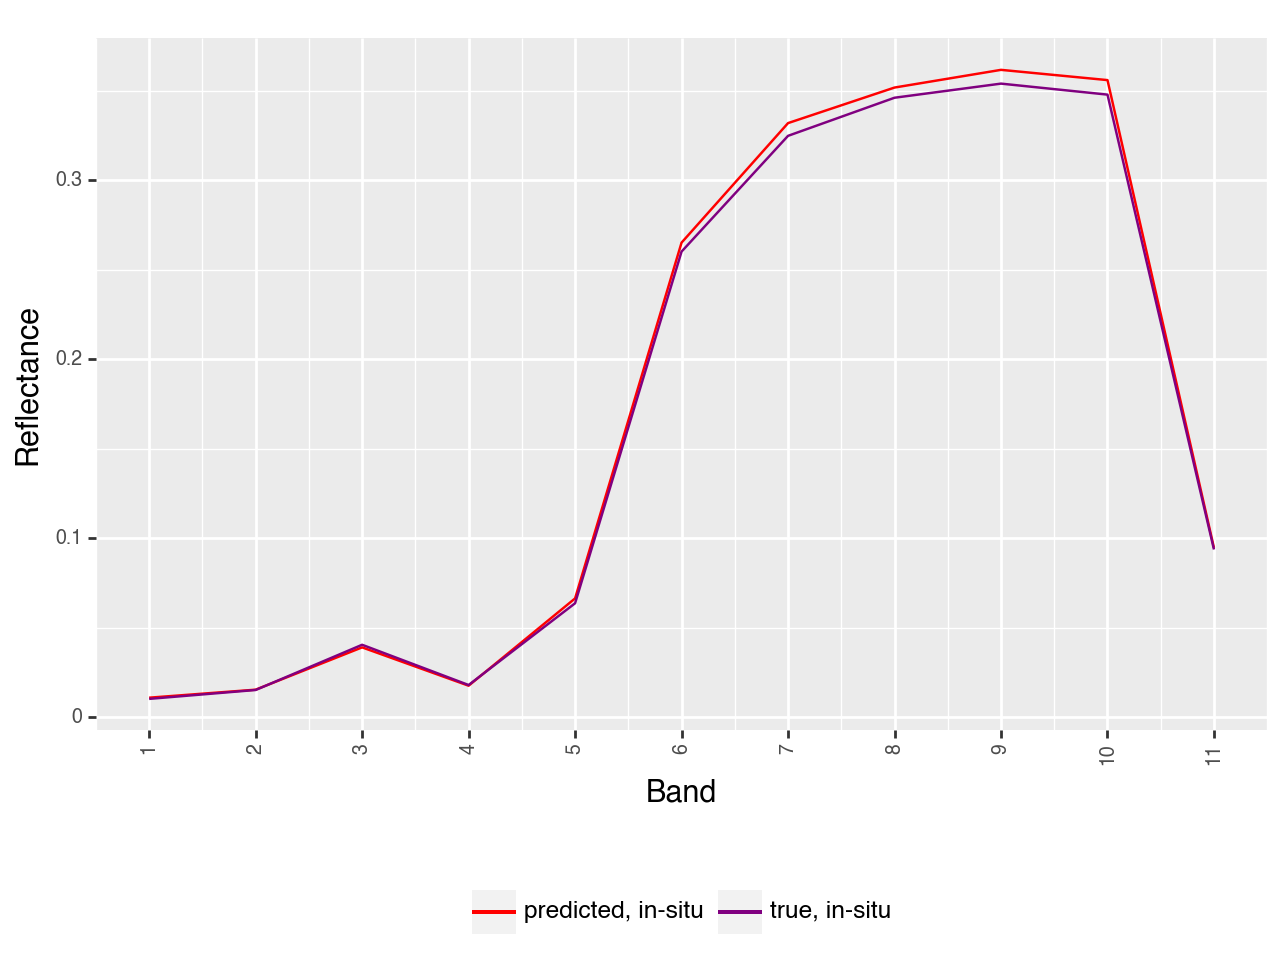

<Figure Size: (640 x 480)>

In [12]:
(ggplot(df_feature_performance_concat.query('cluster == 0'), aes(x='feature_id', y='mean', color='type_'))
                #+ geom_ribbon(aes(ymin='mean-std*2', ymax='mean+std*2'), fill='lightgrey')
                + geom_line()
                #+ facet_wrap("~cluster_", ncol=4)
                + scale_x_continuous(breaks=np.arange(1, 12, 1))
                #+ scale_y_continuous(breaks=np.arange(0, 2.1, 0.2))
                + scale_color_manual(values=['red', 'purple'], labels=['predicted, in-situ', 'true, in-situ'])
                + xlab("Band")
                + ylab("Reflectance")
                + theme(
                    axis_text_x=element_text(size=7, rotation=90),
                    axis_text_y=element_text(size=7),
                    strip_text=element_text(size=7),
                    legend_position="bottom"
                )
                + labs(color='')
        )